In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mne
from tqdm import tqdm 
import numpy as np 
from sklearn.decomposition import PCA 
from sklearn.decomposition import KernelPCA
from scipy.sparse.linalg import svds

In [3]:
raw = mne.io.read_raw_eeglab('sep_uwgr_prepro.set', preload=False)
events, event_id = mne.events_from_annotations(raw)

tmin = -0.05
tmax = 0.22

epochs = mne.Epochs(raw, events, event_id, tmin, tmax, baseline=None, preload=False)

Reading /data/hu_kamm/eeg_llm/sep_uwgr_prepro.fdt


/tmp/ipykernel_1237223/2354897670.py:1: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_raw_eeglab('sep_uwgr_prepro.set', preload=False)


Used Annotations descriptions: [np.str_('1')]
Not setting metadata
6038 matching events found
No baseline correction applied
0 projection items activated


In [4]:
data = epochs.get_data()
avg_data = epochs.average().data

Loading data for 6038 events and 554 original time points ...
0 bad epochs dropped


In [32]:
U, S, Vh = svds(avg_data, k=2)

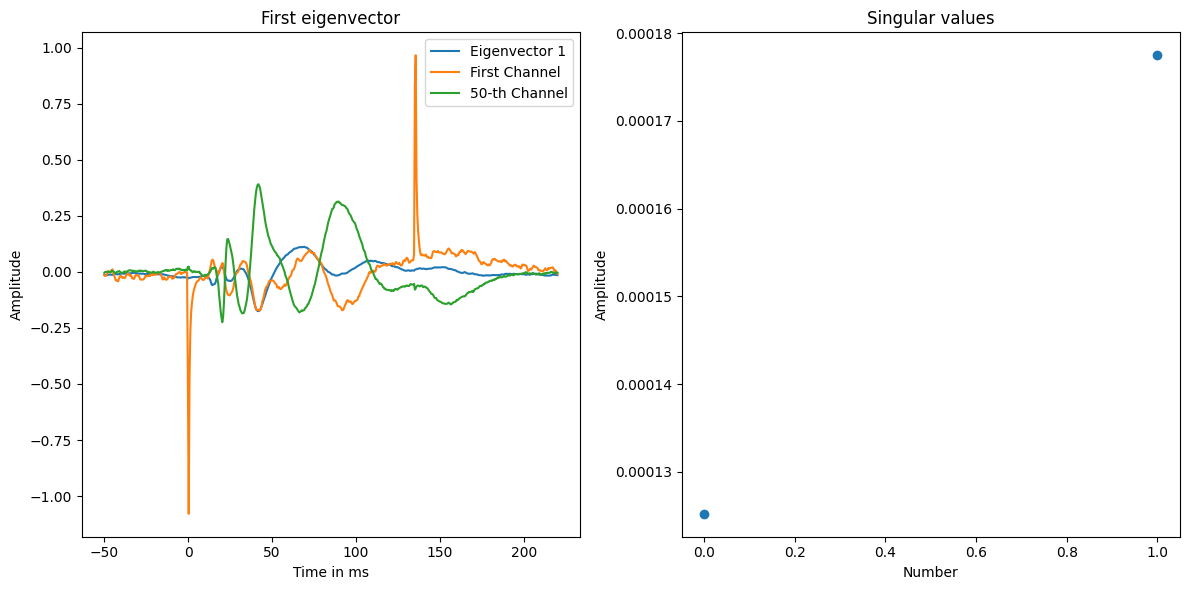

In [35]:
timepoints = np.linspace(tmin, tmax, 554)

# Create a figure with two subplots side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot on the first subplot
eig_n = 0

ax1.plot(timepoints * 1000, Vh[eig_n], label=f'Eigenvector {eig_n+1}')
ax1.plot(timepoints * 1000, avg_data[0] * 100000, label=f'First Channel')
ax1.plot(timepoints * 1000, avg_data[49] * 100000, label=f'50-th Channel')
ax1.set_title(f'First eigenvector')
ax1.set_xlabel('Time in ms')
ax1.set_ylabel('Amplitude')
ax1.legend()

# Plot on the second subplot
ax2.plot(S,'o')
ax2.set_title('Singular values')
ax2.set_xlabel('Number')
ax2.set_ylabel('Amplitude')

# Display the plots
plt.tight_layout()
plt.show()

In [9]:
data_reshaped = data.reshape((3345052, 253))

In [10]:
proj_U1 = np.dot(U[:, 0], data_reshaped.T)
proj_U2 = np.dot(U[:, 1], data_reshaped.T)

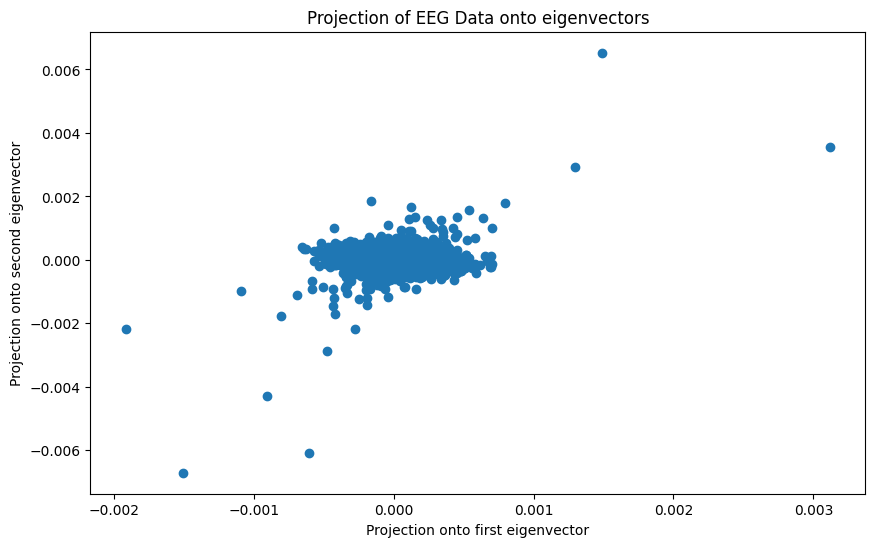

In [11]:
# data is more elongated around first eigenvector
plt.figure(figsize=(10, 6))
plt.scatter(proj_U1, proj_U2)
plt.xlabel('Projection onto first eigenvector')
plt.ylabel('Projection onto second eigenvector')
plt.title('Projection of EEG Data onto eigenvectors')
plt.show()

In [33]:
proj_U1 = np.dot(U.T[0], data)
proj_U2 = np.dot(U.T[1], data)

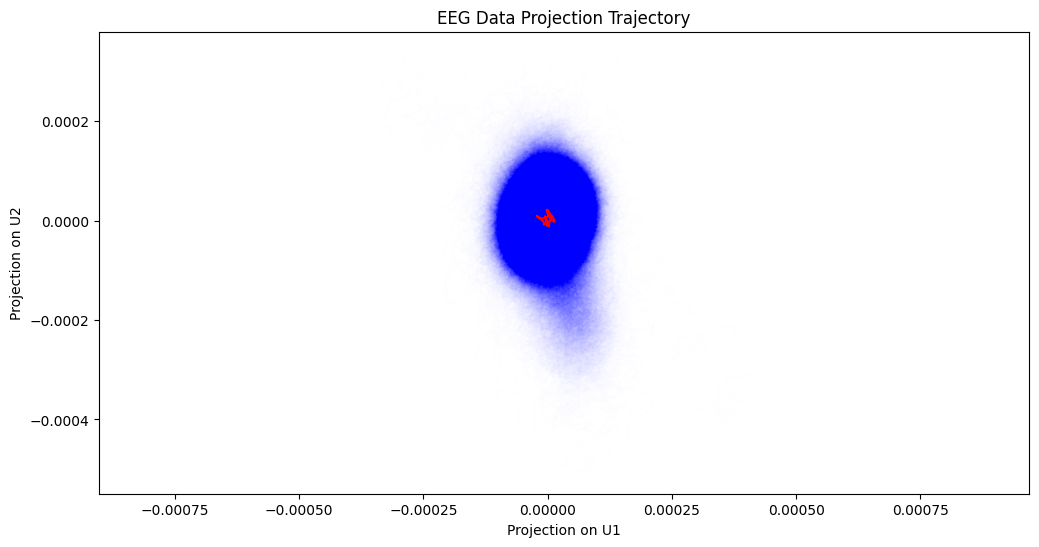

In [34]:
# Plot the trajectory (proj_U1 vs proj_U2)
plt.figure(figsize=(12, 6))
for trial_U1, trial_U2 in zip(proj_U1, proj_U2):
    plt.plot(trial_U1, trial_U2, alpha=0.002, color='blue')  # Each trial

plt.plot(S[0]*Vh[0], S[1]*Vh[1], color='red')

# Add labels and title
plt.xlabel('Projection on U1')
plt.ylabel('Projection on U2')
plt.title('EEG Data Projection Trajectory')

# Show the plot
plt.axis('equal')
plt.show()

In [81]:
# get epochs, channels and timepoints and create list to store principle components for each epoch 
epochs, channels, timepoints = data.shape
components_list = []


for epoch in tqdm(range(epochs)):
    # get data for each epoch 
    epoch_data = data[epoch, :, :]
    epoch_data = epoch_data

    # apply PCA 
    pca =  PCA(n_components=2)
    pca.fit(epoch_data)

    # get first two principle components
    components = pca.components_
    components_list.append(components)

# get mean over all epochs
components_array = np.array(components_list)
avg_components = np.mean(components_array, axis=0)

100%|██████████| 6038/6038 [00:11<00:00, 532.57it/s]


In [79]:
# apply PCA to average data 
pca = PCA(n_components=2)
pca.fit(avg_data)

first_two_comp = pca.components_

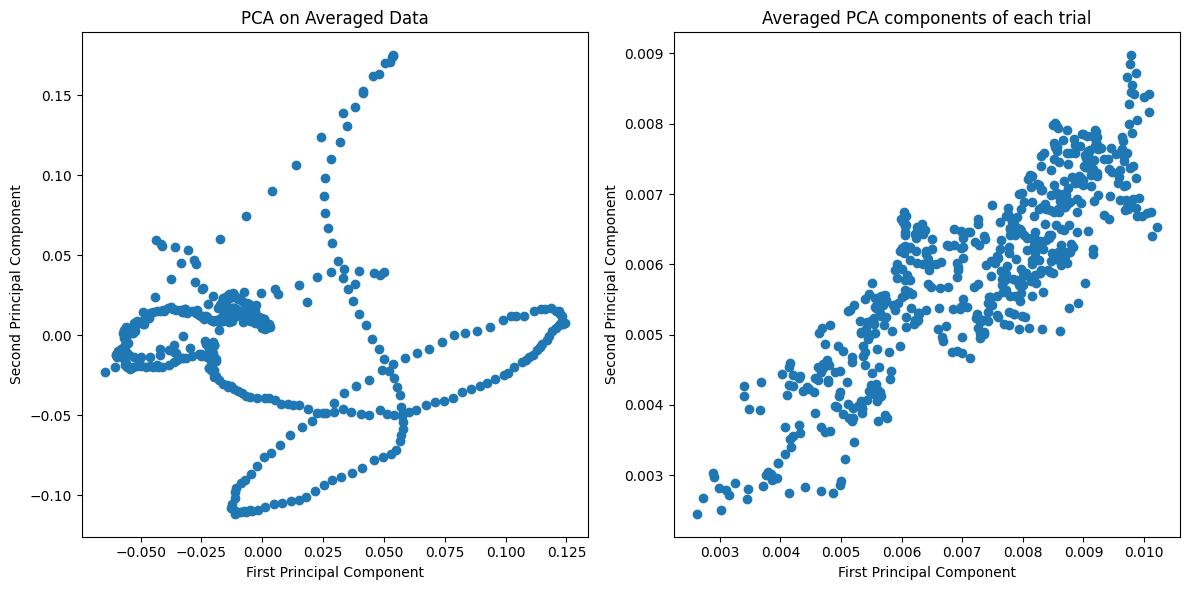

In [82]:
# create figure with two subplots 
fig, axes = plt.subplots(1, 2, figsize=(12,6))

# first subplot of eigenvectors of averaged data 
axes[0].scatter(first_two_comp[0], first_two_comp[1])
axes[0].set_title('PCA on Averaged Data')
axes[0].set_xlabel('First Principal Component')
axes[0].set_ylabel('Second Principal Component')

# second subplot of averaged eigenvectors of each trial 
axes[1].scatter(avg_components[0], avg_components[1])
axes[1].set_title('Averaged PCA components of each trial')
axes[1].set_xlabel('First Principal Component')
axes[1].set_ylabel('Second Principal Component')


plt.tight_layout()
plt.show()

In [25]:
# The second approach looks to be more structured and may be containing more information, so let's try to examine that with SVD
U_avg = []
S_avg = []
Vh_avg = []  
for epoch in tqdm(range(epochs)):
    U, S, Vh = svds(data[epoch, :, :], k=2)
    U_avg.append(U)
    S_avg.append(S)
    Vh_avg.append(Vh)

U_avg = np.array(U_avg)
S_avg = np.array(S_avg)
Vh_avg = np.array(Vh_avg)
U_avg = np.mean(U_avg, axis=0)
S_avg = np.mean(S_avg, axis=0)
Vh_avg = np.mean(Vh_avg, axis=0)
    

100%|██████████| 6038/6038 [00:07<00:00, 762.41it/s]


In [27]:
proj_U1_avg = np.dot(U_avg.T[0], data)
proj_U2_avg = np.dot(U_avg.T[1], data)

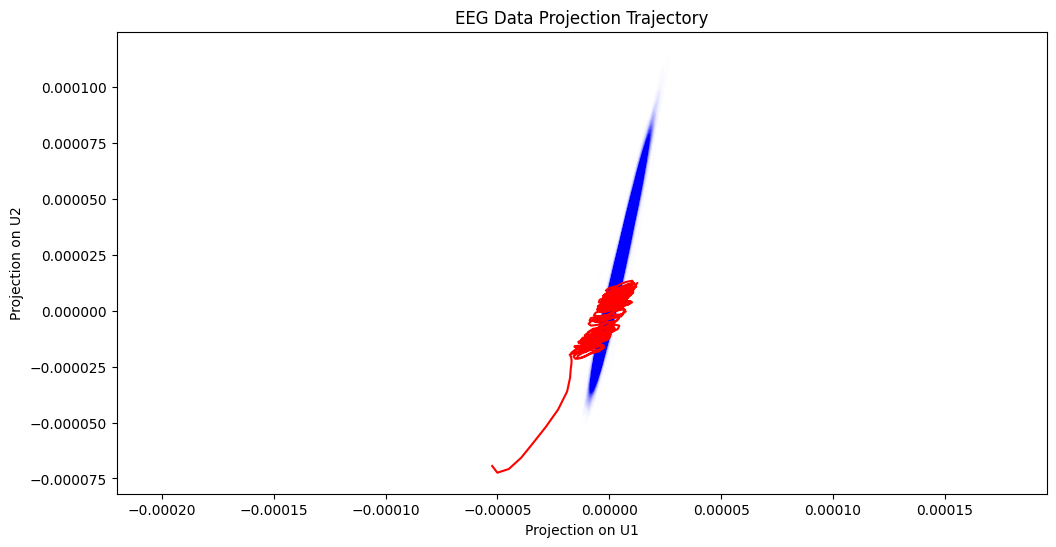

In [31]:
# Plot the trajectory (proj_U1 vs proj_U2)
plt.figure(figsize=(12, 6))
for trial_U1, trial_U2 in zip(proj_U1_avg, proj_U2_avg):
    plt.plot(trial_U1, trial_U2, alpha=0.002, color='blue')  # Each trial

plt.plot(S_avg[0]*Vh_avg[0], S_avg[1]*Vh_avg[1], color='red')

# Add labels and title
plt.xlabel('Projection on U1')
plt.ylabel('Projection on U2')
plt.title('EEG Data Projection Trajectory')

# Show the plot
plt.axis('equal')
plt.show()

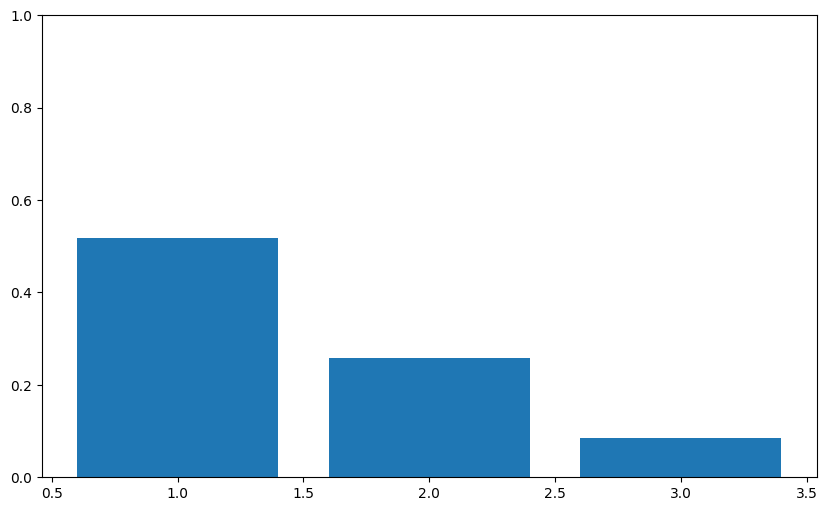

In [49]:
# get explained variance of linear PCA 
pca = PCA(n_components=3)
pca.fit(avg_data.T)

explained_var_ratio = pca.explained_variance_ratio_

plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_var_ratio) + 1), explained_var_ratio, align='center')
plt.ylim(0, 1)
plt.show()

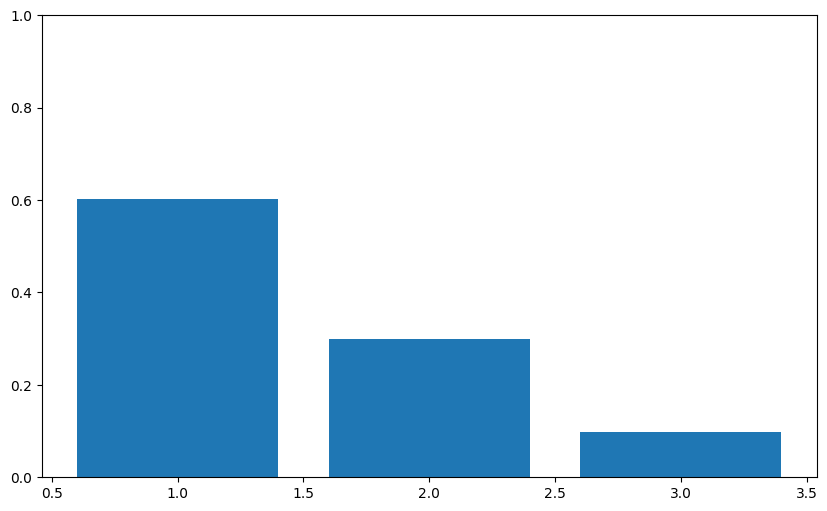

In [72]:
# get the importance of eigenvalues for KernelPCA, note that the explained variance ratio cannot be computed explitely, since the kernel matrix does not correspond to the covariance matrix 
kpca = KernelPCA(kernel='rbf', n_components=3)
kpca.fit(avg_data.T)

lambdas = kpca.eigenvalues_
explained_variance_ratio = lambdas / np.sum(lambdas)

plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, align='center')
plt.ylim(0, 1)
plt.show()

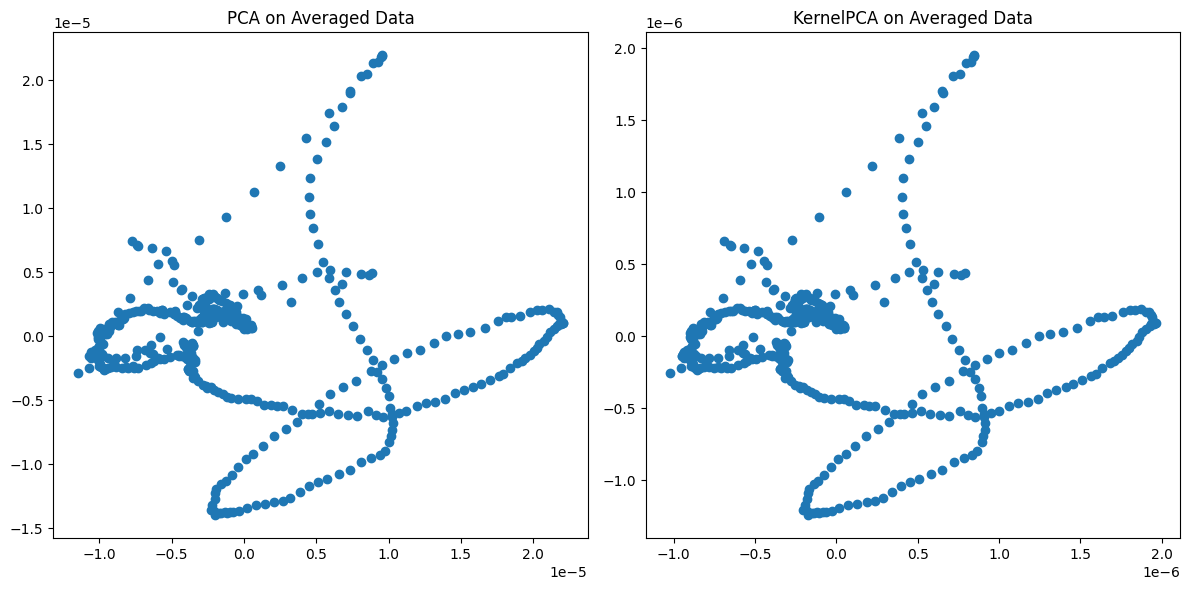

In [75]:
# This may indicate that KernelPCA works a little bit better when downprojecting the data, let's examine this 
pca_transf = pca.fit_transform(avg_data.T)
kpca_transf = kpca.fit_transform(avg_data.T)

fig, axes = plt.subplots(1, 2, figsize=(12,6))

axes[0].scatter(pca_transf[:, 0], pca_transf[:, 1])
axes[0].set_title('PCA on Averaged Data')

axes[1].scatter(kpca_transf[:, 0], kpca_transf[:, 1])
axes[1].set_title('KernelPCA on Averaged Data')

plt.tight_layout()
plt.show()

In [ ]:
# As can be seen KernelPCA did not accomplish anything, which Linear PCA was not already capable of doing